# TTS Inference Model Selection

This notebook can be used to generate audio samples using either NeMo's pretrained models or after training NeMo TTS models. This notebook supports all TTS models and is intended to showcase different models and how their results differ.

# License

> Copyright 2020 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [14]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
BRANCH = 'r1.11.0'
# # If you're using Google Colab and not running locally, uncomment and run this cell.
!apt-get install sox libsndfile1 ffmpeg
!pip install wget unidecode
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/main/nemo_text_processing/install_pynini.sh
!bash install_pynini.sh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
sox is already the newest version (14.4.2-3ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/NVIDIA/NeMo.git (to revision r1.11.0) to /tmp/pip-install-48ybzg75/nemo-toolkit_1a8cf24458c44e5f9005949ba07473e4
  Running command git clone -q https://github.com/NVIDIA/NeMo.git /tmp/pip-install-48ybzg75/nemo-toolkit_1a8cf24458c44e5f9005949ba07473e4
  Running command git checkout -b r1.

## Models

First we pick the models that we want to use. Currently supported models are:

Spectrogram Generators:
- [Tacotron 2](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_tacotron2)
- [FastPitch](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_fastpitch)
- [Mixer-TTS](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_lj_mixertts)
- [Mixer-TTS-X](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_lj_mixerttsx)

Audio Generators
- [WaveGlow](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_waveglow_88m)
- [HiFiGAN](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_hifigan)
- [UnivNet](https://ngc.nvidia.com/catalog/models/nvidia:nemo:tts_en_lj_univnet)
- Griffin-Lim

In [15]:
from ipywidgets import Select, HBox, Label
from IPython.display import display

supported_spec_gen = ["tacotron2", "fastpitch", "mixertts", "mixerttsx","fastspeech2","talknet", None]
supported_audio_gen = ["waveglow", "hifigan", "univnet", "griffin-lim", None]

print("Select the model(s) that you want to use. Please choose 1 spectrogram generator and 1 vocoder.")
spectrogram_generator_selector = Select(options=supported_spec_gen, value=None)
audio_generator_selector = Select(options=supported_audio_gen, value=None)
display(HBox([spectrogram_generator_selector, Label("+"), audio_generator_selector]))

Select the model(s) that you want to use. Please choose 1 spectrogram generator and 1 vocoder.


In [16]:
spectrogram_generator = spectrogram_generator_selector.value
audio_generator = audio_generator_selector.value

if spectrogram_generator is None and audio_generator is None:
    raise ValueError("No models were chosen. Please return to the previous step and choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.")

if (spectrogram_generator and audio_generator is None) or (audio_generator and spectrogram_generator is None):
    raise ValueError("In order to continue with the two step pipeline, both the spectrogram generator and the audio generator must be chosen, but one was `None`")

## Load model checkpoints

Next we load the pretrained model provided by NeMo. All NeMo models have two functions to help with this

- list_available_models(): This function will return a list of all pretrained checkpoints for that model
- from_pretrained(): This function will download the pretrained checkpoint, load it, and return an instance of the model

Below we will use `from_pretrained` to load the chosen models from above.

In [17]:
from omegaconf import OmegaConf, open_dict
import torch
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder, TextToWaveform


def load_spectrogram_model():
    override_conf = None
    
    from_pretrained_call = SpectrogramGenerator.from_pretrained
    
    if spectrogram_generator == "tacotron2":
        from nemo.collections.tts.models import Tacotron2Model
        pretrained_model = "tts_en_tacotron2"
    elif spectrogram_generator == "fastpitch":
        from nemo.collections.tts.models import FastPitchModel
        pretrained_model = "tts_en_fastpitch"
    elif spectrogram_generator == "mixertts":
        from nemo.collections.tts.models import MixerTTSModel
        pretrained_model = "tts_en_lj_mixertts"
    elif spectrogram_generator == "mixerttsx":
        from nemo.collections.tts.models import MixerTTSModel
        pretrained_model = "tts_en_lj_mixerttsx"
    elif spectrogram_generator == "fastspeech2":
        from nemo.collections.tts.models import FastSpeech2Model
        pretrained_model = "tts_en_fastspeech2"
    elif spectrogram_generator == "talknet":
        from nemo.collections.tts.models import TalkNetSpectModel
        pretrained_model = "tts_en_talknet"
    else:
        raise NotImplementedError
        
    model = from_pretrained_call(pretrained_model, override_config_path=override_conf)
    
    return model


def load_vocoder_model():
    TwoStagesModel = False
    strict=True
    
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel
        pretrained_model = "tts_waveglow"
        strict=False
    elif audio_generator == "hifigan":
        from nemo.collections.tts.models import HifiGanModel
        spectrogram_generator2ft_hifigan = {
            "mixertts": "tts_en_lj_hifigan_ft_mixertts",
            "mixerttsx": "tts_en_lj_hifigan_ft_mixerttsx"
        }
        pretrained_model = spectrogram_generator2ft_hifigan.get(spectrogram_generator, "tts_hifigan")
    elif audio_generator == "univnet":
        from nemo.collections.tts.models import UnivNetModel
        pretrained_model = "tts_en_lj_univnet"
    elif audio_generator == "griffin-lim":
        from nemo.collections.tts.models import TwoStagesModel
        cfg = {'linvocoder':  {'_target_': 'nemo.collections.tts.models.two_stages.GriffinLimModel',
                             'cfg': {'n_iters': 64, 'n_fft': 1024, 'l_hop': 256}},
               'mel2spec': {'_target_': 'nemo.collections.tts.models.two_stages.MelPsuedoInverseModel',
                           'cfg': {'sampling_rate': 22050, 'n_fft': 1024, 
                                   'mel_fmin': 0, 'mel_fmax': 8000, 'mel_freq': 80}}}
        model = TwoStagesModel(cfg)            
        TwoStagesModel = True
    else:
        raise NotImplementedError

    if not TwoStagesModel:
        model = Vocoder.from_pretrained(pretrained_model, strict=strict)
        
    return model

spec_gen = load_spectrogram_model().eval()
vocoder = load_vocoder_model().eval()

[NeMo I 2022-09-25 17:58:01 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.0.0/files/tts_en_tacotron2.nemo to /root/.cache/torch/NeMo/NeMo_1.11.0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo
[NeMo I 2022-09-25 17:58:07 common:910] Instantiating model from pre-trained checkpoint


[NeMo W 2022-09-25 17:58:09 modelPT:143] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      trim: false
      int_values: false
      load_audio: true
      normalize: true
      sample_rate: 22050
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 48
      num_workers: 4
    
[NeMo W 2022-09-25 17:58:09 modelPT:150] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_

[NeMo I 2022-09-25 17:58:09 features:223] PADDING: 16
[NeMo I 2022-09-25 17:58:10 save_restore_connector:243] Model Tacotron2Model was successfully restored from /root/.cache/torch/NeMo/NeMo_1.11.0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo.
[NeMo I 2022-09-25 17:58:10 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_waveglow_88m/versions/1.0.0/files/tts_waveglow.nemo to /root/.cache/torch/NeMo/NeMo_1.11.0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo
[NeMo I 2022-09-25 17:58:23 common:910] Instantiating model from pre-trained checkpoint


[NeMo W 2022-09-25 17:58:27 modelPT:143] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      n_segments: 16000
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 12
      num_workers: 4
    
[NeMo W 2022-09-25 17:58:27 modelPT:150] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_val.json

[NeMo I 2022-09-25 17:58:27 features:223] PADDING: 16


[NeMo W 2022-09-25 17:58:27 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/tts/modules/submodules.py:274: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
    The boolean parameter 'some' has been replaced with a string parameter 'mode'.
    Q, R = torch.qr(A, some)
    should be replaced with
    Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2491.)
      W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
    


[NeMo I 2022-09-25 17:58:30 save_restore_connector:243] Model WaveGlowModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.11.0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo.


## Inference

Now that we have downloaded the model checkpoints and loaded them into memory. Let's define a short infer helper function that takes a string, and our models to produce speech.

Notice that the NeMo TTS model interface is fairly simple and standardized across all models.

End-to-end models have two helper functions:
- parse(): Accepts raw python strings and returns a torch.tensor that represents tokenized text
- convert_text_to_waveform(): Accepts a batch of tokenized text and returns a torch.tensor that represents a batch of raw audio

Mel Spectrogram generators have two helper functions:

- parse(): Accepts raw python strings and returns a torch.tensor that represents tokenized text
- generate_spectrogram(): Accepts a batch of tokenized text and returns a torch.tensor that represents a batch of spectrograms

Vocoder have just one helper function:

- convert_spectrogram_to_audio(): Accepts a batch of spectrograms and returns a torch.tensor that represents a batch of raw audio

In [18]:
def infer(spec_gen_model, vocoder_model, str_input):
    parser_model = spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        gen_spec_kwargs = {}
        
        if spectrogram_generator == "mixerttsx":
            gen_spec_kwargs["raw_texts"] = [str_input]
        
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, **gen_spec_kwargs)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
        if audio_generator == "hifigan":
            audio = vocoder_model._bias_denoise(audio, spectrogram).squeeze(1)
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

Now that everything is set up, let's give an input that we want our models to speak

In [19]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(spec_gen, vocoder, text_to_generate)

Input what you want the model to say: hello, brother


[NeMo W 2022-09-25 17:59:09 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/functional.py:607: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:800.)
      normalized, onesided, return_complex)
    


# Results

After our model generates the audio, let's go ahead and play it. We can also visualize the spectrogram that was produced from the first stage model if a spectrogram generator was used.

In [20]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

ipd.Audio(audio, rate=22050)

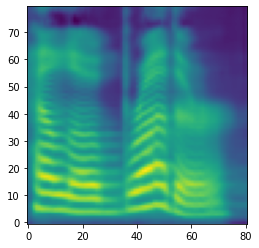

In [21]:
%matplotlib inline
if spec is not None:
    imshow(spec, origin="lower")
    plt.show()